# 第3章 ランダム現象の例

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from numpy.random import *

### 参考
* [Pythonで常微分方程式を解く](https://qiita.com/tobira-code/items/d76ed91a88f112b4a474)

### 乱数シードの指定（テキスト掲載用）

拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [2]:
np.random.seed(123)

## 3.1 射撃実験

In [3]:
m = 1
c = 0.0051
g = 9.8
t0 = 0.0
v0 = 800.0 * np.array([np.cos(1e-3), np.sin(1e-3)])
Dt = 0.001
inv_sqrtDt = 1.0/np.sqrt(Dt) 

def eom(t, xx, ff): # 式(3.1)の運動方程式
    # xx[0]=x, xx[1]=dx/dt, xx[2]=y, xx[3]=dy/dt
    # 外乱　ff[0]=x成分, ff[1]=y成分
    dx = [ xx[1], \
           ( -c*np.abs(xx[1])*xx[1] + ff[0] )/m, \
           xx[3], \
           ( -c*np.abs(xx[3])*xx[3] -m*g + ff[1] )/m ]
    return dx

solver = ode(eom).set_integrator('dopri5')
#solver = ode(eom).set_integrator('vode', method='adams')

def get_random_motion(seed_num, noise_intensity):
    solver.set_initial_value( [0, v0[0], 0, v0[1] ], t0 )
    motion = [[0,0]]
    seed(seed_num)
    while solver.y[0] < 100:
        ff = noise_intensity*randn(2)*inv_sqrtDt #不規則な力．/sqrt_Dt はノイズ強度の補正
        solver.set_f_params( ff )
        solver.integrate(solver.t + Dt)
        motion += [[ solver.y[0], solver.y[2] ]]
    return np.array(motion)

### 図3.1

In [4]:
motion = get_random_motion(0, 0.0)  # 外乱なし
ts = [(t0 + Dt*i) for i in range(len(motion))]

In [5]:
def plot_motion(motion):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2), sharex=True)
    ax.set_ylim([-2e-2,4e-2])
    ax.set_xlabel('$x$ [m]', fontsize=12)
    ax.set_ylabel('$y$ [m]', fontsize=12)
    ax.grid()
    def plot(mot):
        ax.plot(mot[:,0], mot[:,1], 'k-', linewidth=0.7)
        ax.plot(mot[-1,0], mot[-1,1], 'ko', markersize=5, markerfacecolor='w',
             markeredgewidth=1.0, markeredgecolor='k', alpha=0.7) # 着弾点    
    if isinstance(motion, list):
        for mot in motion:
            plot(mot)
    else:
        plot(motion)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


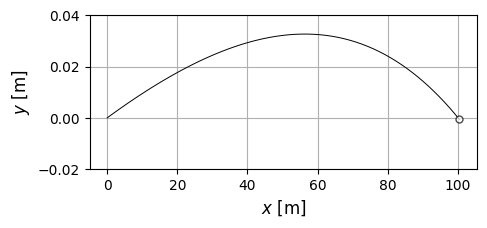

In [6]:
plot_motion(motion)
plt.savefig('figs/Ch03-gun_clean.eps', bbox_inches='tight')

### 図3.2

In [7]:
def get_random_motionS( s, n_sample ):
    return [get_random_motion( 321+i, s ) for i in range(n_sample)] 
    # 321+i は乱数のシード．321は宇都宮市の郵便番号（任意の整数）

In [8]:
%%time
motions20 = get_random_motionS( 0.15, 21 )
xend20 = np.array([a[-1,0] for a in motions20])
yend20 = np.array([a[-1,1] for a in motions20])

CPU times: total: 344 ms
Wall time: 338 ms


《著者PC参考》
```
CPU times: user 186 ms, sys: 4.06 ms, total: 190 ms
Wall time: 193 ms
```

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


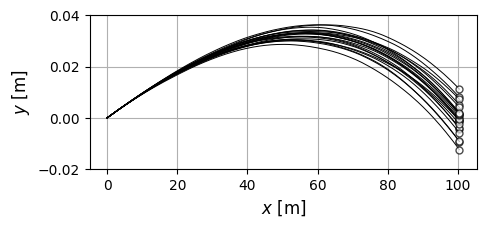

In [9]:
plot_motion(motions20)
plt.savefig('figs/Ch03-gun_20.eps', bbox_inches='tight')

## 3.2 確率変数

### 式(3.2)

In [10]:
Πₙ = yend20
Πₙ

array([-0.00431436, -0.00094219,  0.0004355 , -0.00921597,  0.00798405,
       -0.00108188, -0.00124944,  0.0111891 ,  0.00725296, -0.0038258 ,
       -0.00237745,  0.00508466, -0.00579842, -0.0003055 ,  0.00167325,
        0.00121031,  0.00136634,  0.0040884 , -0.00918951, -0.01240914,
        0.00204542])

In [11]:
Ω = np.array(range(21))

def _Y(ω):
    return yend20[ω]

Y = np.vectorize(_Y)

### 図3.3 確率変数 $Y(\omega)$ for $x=100$

In [12]:
def plot_variable(idx_set, value_set, y_label, idx_set2=None, value_set2=None, markersize=4, xstep=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 1.5), sharex=True)
    ax.set_xlabel('$\omega$', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.plot(idx_set, value_set, 'o', markersize=markersize, markerfacecolor='k',
             markeredgewidth=0.0, markeredgecolor='k', alpha=0.7) # 着弾点
    idx_len=len(idx_set)
    if idx_set2 is not None:
        idx_len += len(idx_set2)
        ax.plot(idx_set2, value_set2, 'o', markersize=1.3*markersize, markerfacecolor='w',
                 markeredgewidth=0.25*markersize, markeredgecolor='k', alpha=0.7) # 着弾点
    ax.grid(which='major',color='black',linestyle='--')
    ax.grid(which='minor',color='black',linestyle='--')
    plt.xticks(np.arange(0, idx_len, xstep))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


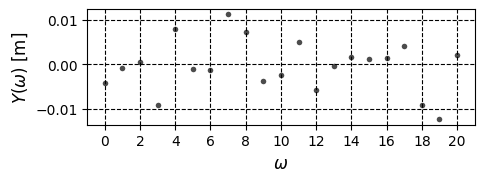

In [13]:
plot_variable(Ω,Y(Ω),'$Y(\omega)$ [m]')
plt.savefig('figs/Ch03-gun_20_Y.eps', bbox_inches='tight')

### 図3.4 確率変数 $Z(\omega)$ for $x=60$

In [14]:
yend20_x60=np.array([motion[motion[:,0]<60][-1,1] for motion in motions20])
yend20_x60

array([0.03161607, 0.03256218, 0.03270947, 0.02923083, 0.03624681,
       0.02968529, 0.0315868 , 0.03613026, 0.03360691, 0.03127163,
       0.03063509, 0.03313168, 0.02993802, 0.03270275, 0.03527321,
       0.03287142, 0.03310423, 0.03421127, 0.02967569, 0.02737478,
       0.03409464])

In [15]:
def _Z(ω):
    return yend20_x60[ω]

Z = np.vectorize(_Z)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


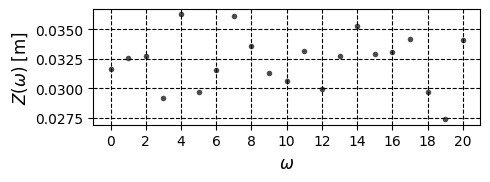

In [16]:
plot_variable(Ω,Z(Ω),'$Z(\omega)$ [m]')
plt.savefig('figs/Ch03-gun_20_Z.eps', bbox_inches='tight')

### 図3.5 確率変数 $Y(\omega)$ for $x=100$,  $\#\Omega=501$

In [17]:
%%time
motions500 = get_random_motionS( 0.15, 501 )

CPU times: total: 6.97 s
Wall time: 7.03 s


《著者PC参考》
```
CPU times: user 4.19 s, sys: 0 ns, total: 4.19 s
Wall time: 4.18 s
```

In [18]:
yend500 = np.array([a[-1,1] for a in motions500])

In [19]:
Ω500 = np.array(range(501))

def _Y500(ω):
    return yend500[ω]

Y500 = np.vectorize(_Y500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


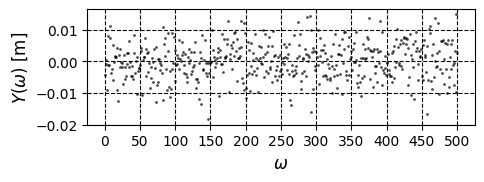

In [20]:
plot_variable(Ω500,Y500(Ω500),'$Y(\omega)$ [m]', markersize=2, xstep=50)
plt.savefig('figs/Ch03-gun_500_Y.eps', bbox_inches='tight')

### おまけ 確率変数 $Z(\omega)$ for $x=60$,  $\#\Omega=501$

In [21]:
yend500_x60=np.array([motion[motion[:,0]<60][-1,1] for motion in motions500])

In [22]:
def _Z500(ω):
    return yend500_x60[ω]

Z500 = np.vectorize(_Z500)

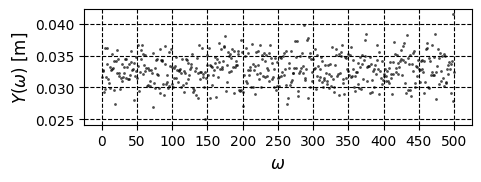

In [23]:
plot_variable(Ω500,Z500(Ω500),'$Y(\omega)$ [m]', markersize=2, xstep=50)

### おまけ 確率変数 $X(\omega)$, $Z(\omega)$ for $\#\Omega=5001$

In [24]:
%%time
motions5000 = get_random_motionS( 0.15, 5001 )
yend5000 = np.array([a[-1,1] for a in motions5000])
yend5000_x60=np.array([motion[motion[:,0]<60][-1,1] for motion in motions5000])

CPU times: total: 1min 18s
Wall time: 1min 31s


《著者PC参考》
```
CPU times: user 41.2 s, sys: 342 ms, total: 41.6 s
Wall time: 40.9 s
```

後で使うので保存しておく．

In [25]:
np.save('Ch03_Ydata500.npy', yend500)
np.save('Ch03_Zdata500.npy', yend500_x60)
np.save('Ch03_Ydata5000.npy', yend5000)
np.save('Ch03_Zdata5000.npy', yend5000_x60)

## 3.3 事象と確率

## 3.3.2 事象

### 図3.6 事象 {$|Y | \leq 10^{−3}$} の抽出

In [26]:
A = np.where(np.abs(yend20)<1e-3)[0]  #着目した事象
Ac = np.setdiff1d(Ω,A)  #その余事象

In [27]:
A

array([ 1,  2, 13], dtype=int64)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


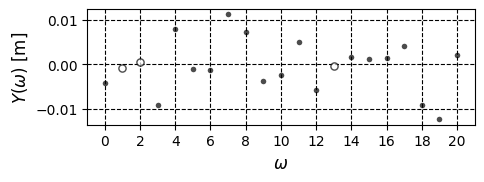

In [28]:
plot_variable(Ac, Y(Ac), '$Y(\omega)$ [m]', A, Y(A))
plt.savefig('figs/Ch03-gun_20_Yev.eps', bbox_inches='tight')

### 図3.7 事象 {$|Y | \leq 10^{−3}$} の抽出 for $\#\Omega=501$

In [29]:
A500 = np.where(np.abs(yend500)<1e-3)[0]  #着目した事象
Ac500 = np.setdiff1d(Ω500,A500)  #その余事象

In [30]:
A500

array([  1,   2,  13,  23,  25,  31,  36,  44,  54,  63,  69,  75,  77,
        79,  97, 102, 104, 107, 108, 120, 121, 134, 136, 141, 143, 146,
       149, 150, 151, 157, 158, 159, 165, 166, 177, 191, 210, 214, 217,
       220, 222, 223, 236, 252, 253, 255, 259, 273, 281, 289, 308, 316,
       317, 338, 348, 353, 355, 356, 364, 369, 371, 389, 400, 401, 413,
       417, 436, 444, 468, 481, 496], dtype=int64)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


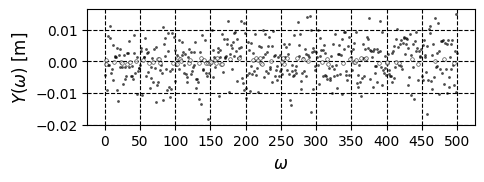

In [31]:
plot_variable(Ac500, Y500(Ac500), '$Y(\omega)$ [m]', A500, Y500(A500), xstep=50, markersize=2)
plt.savefig('figs/Ch03-gun_500_Yev.eps', bbox_inches='tight')

## 3.3.3 確率

In [32]:
def get_yends( s, n_sample ):
    return np.array([get_random_motion( 321+i, s )[-1,1] for i in range(n_sample)])

In [33]:
%%time
Πhuge = get_yends(0.15,15000)

CPU times: total: 3min 40s
Wall time: 3min 47s


《著者PC参考》
```
CPU times: user 2min 3s, sys: 1.44 s, total: 2min 4s
Wall time: 2min 1s
```

In [34]:
Πbin = np.where(np.abs(Πhuge)<1e-3, 1, 0)

In [35]:
Πbin

array([0, 1, 1, ..., 0, 0, 0])

In [36]:
np.mean(Πbin)

0.13773333333333335

In [37]:
nΩ=np.array(range(10,15000+1,10))

In [38]:
nΩ

array([   10,    20,    30, ..., 14980, 14990, 15000])

In [39]:
P_of_n = [np.mean(Πbin[:n]) for n in nΩ]

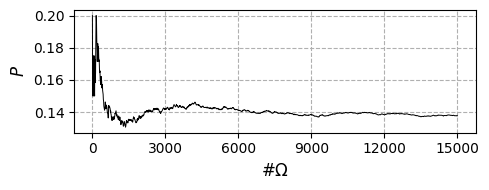

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2), sharex=True)
ax.set_xlabel('$\#\Omega$', fontsize=12)
ax.set_ylabel('$P$', fontsize=12)
ax.grid(linestyle='--')
plt.xticks(np.arange(0, max(nΩ)+1, 3000))
ax.plot(nΩ,P_of_n,'k-',linewidth=0.7)
plt.tight_layout()
plt.savefig('figs/Ch03-gun_YevP.eps', bbox_inches='tight')